In [28]:
#DTW calculation

import pandas as pd
import numpy as np
import os
import glob 
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter
from scipy.fftpack import fft
from dtw import dtw
from numpy import array, zeros, argmin, inf, ndim
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
# from quatrotate import qv_mult # this routine implements rotation via quaternion multiplication

%matplotlib inline

In [29]:
#read csv file and return its data-frame
def read_csv_file(acc, gyro, mode):
    df_gyro = pd.read_csv(gyro, index_col=False)
    df      = pd.read_csv(acc,  index_col=False)
    df.rename(columns = {'X': 'AX', 'Y':'AY', 'Z':'AZ'}, inplace = True)
    df['GX'] = df_gyro['X']
    df['GY'] = df_gyro['Y']
    df['GZ'] = df_gyro['Z']
    
    df['activity'] = mode
    
    return df

In [30]:
def GaussianFilter(df, window_length):
    df1 = df
    df1['AX'] = gaussian_filter(df['AX'], window_length)
    df1['AY'] = gaussian_filter(df['AY'], window_length)
    df1['AZ'] = gaussian_filter(df['AZ'], window_length)

    df1['GX'] = gaussian_filter(df['GX'], window_length)
    df1['GY'] = gaussian_filter(df['GY'], window_length)
    df1['GZ'] = gaussian_filter(df['GZ'], window_length)
    
    return df1

In [31]:
def Mean(df, input_features, out_feature):
    df[out_feature] = (df[input_features[0]] + df[input_features[1]]  + df[input_features[2]])/3
    
    return df
    
    

In [32]:
"""
Rotate a 3D vector using the axis-angle method (quaternions).
"""

import numpy as np


def normalize(v, tolerance=0.00001):
    mag2 = sum(n * n for n in v)
    if abs(mag2 - 1.0) > tolerance:
        mag = np.sqrt(mag2)
        v = tuple(n / mag for n in v)
    return v

def q_mult(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 + y1 * w2 + z1 * x2 - x1 * z2
    z = w1 * z2 + z1 * w2 + x1 * y2 - y1 * x2
    return w, x, y, z

def q_conjugate(q):
    w, x, y, z = q
    return (w, -x, -y, -z)

def qv_mult(q1, v1):
    q2 = (0.0,) + v1
    return q_mult(q_mult(q1, q2), q_conjugate(q1))[1:]

def axisangle_to_q(v, theta):
    v = normalize(v)
    x, y, z = v
    theta /= 2
    w = np.cos(theta)
    x = x * np.sin(theta)
    y = y * np.sin(theta)
    z = z * np.sin(theta)
    return w, x, y, z

def q_to_axisangle(q):
    w, v = q[0], q[1:]
    theta = np.acos(w) * 2.0
    return normalize(v), theta

In [33]:
def get_rotation(quatern, vector):
    rotaedvector = []
    for i in range(vector.shape[0]):
        rotaedvector.append(qv_mult(tuple(quatern[i,:]), tuple(vector[i,:])))
    return np.array(rotaedvector)

In [34]:
def rotate(df):
    features = ['A', 'G']
    quaternion = df[['motionQuaternionW', 'motionQuaternionX',
                     'motionQuaternionY','motionQuaternionZ']].values
    
    for f in features:
        print('...'+ f)
        xyzlist = [f + 'X', f + 'Y', f + 'Z']
        xyz = df[xyzlist].values
        xyz_rotated = get_rotation(quaternion, xyz)
        df[f + 'X'] = xyz_rotated[:,0]
        df[f + 'Y'] = xyz_rotated[:,1]
        df[f + 'Z'] = xyz_rotated[:,2]
        

In [35]:
def rotate(df):

    """ Generate rdf, a rotated version of df where the z-axis is aligned
    with gravity. """

    varlist = ['accelerometerAcceleration', 'motionUserAcceleration',
            'motionGravity', 'motionMagneticField', 'gyroRotation']

    quaternion = df[['motionQuaternionW', 'motionQuaternionX', 
        'motionQuaternionY', 'motionQuaternionZ']].values

    for ivar in varlist:
        print("..." + ivar)
        xyzlist = [ivar + 'X', ivar + 'Y', ivar + 'Z']
        xyz = df[xyzlist].values
        xyz_rotated = getrot(quaternion, xyz)
        df[ivar + 'X'] = xyz_rotated[:, 0]
        df[ivar + 'Y'] = xyz_rotated[:, 1]
        df[ivar + 'Z'] = xyz_rotated[:, 2]

In [36]:
#generate frequency domain data from time domain data usinf Fast Fourier transformation

def FFT(df, input_features, output_features):
    
    for i in range(len(input_features)):
        reals = np.real(np.fft.rfft(df[input_features[i]]))
        imagn = np.imag(np.fft.rfft(df[input_features[i]]))

        complexs = [reals[0]]
        n = len(reals)
        if(n%2 == 0):
            complexs.append(imagn[0])
        for j in range(1, n-1):
            complexs.append(reals[j])
            complexs.append(imagn[j])
        if( len(df) > len(complexs)):
            complexs.append(reals[j])
        if( len(df) > len(complexs)):
            complexs.append(imagn[j])
            
        df[output_features[i]] = complexs
    return df

In [37]:
def data_preprocessing(df):
#     df['Milliseconds'] =df['Milliseconds']/1000 
    #apply gaussian filter with window size 5
    df = GaussianFilter(df, 10)
    
    #mean feature of 3-axis accelerometer data
    input_features = ['AX', 'AY', 'AZ']
    output_feature = 'mAcc'
    df = Mean(df, input_features, output_feature)
    
    #mean feature of 3-axis gyroscope data
    input_features = ['GX', 'GY', 'GZ']
    output_feature = 'mGyro'
    df = Mean(df, input_features, output_feature)
    
    #Frequency domain feature generation from time series accelerometer data
    input_features = ['AX', 'AY', 'AZ']
    output_feature = ['fAX', 'fAY', 'fAZ']
    df = FFT(df, input_features, output_feature)
    
    #Frequency domain feature generation from time series gyroscope data
    input_features = ['AX', 'AY', 'AZ']
    output_feature = ['fGX', 'fGY', 'fGZ']
    df = FFT(df, input_features, output_feature)
    
    return df
    
    
    
    
    

In [38]:
def segmentation(df, N_TIME_STEPS):
    
    N_FEATURES = 1
    step = 50
    segments = []
    labels = []
    for i in range(0, len(df) - N_TIME_STEPS, step):
        gx = df['GX'].values[i: i + N_TIME_STEPS]
        gy = df['GY'].values[i: i + N_TIME_STEPS]
        gz = df['GZ'].values[i: i + N_TIME_STEPS]
        ax = df['AX'].values[i: i + N_TIME_STEPS]
        ay = df['AY'].values[i: i + N_TIME_STEPS]
        az = df['AZ'].values[i: i + N_TIME_STEPS]
        label = "ST"
        segments.append([gx, gy, gz, ax, ay, az])
#         labels = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
        labels.append(label)
    return segments, labels

In [78]:
# def dtw(x, y, dist, warp=1):
#     """
#     Computes Dynamic Time Warping (DTW) of two sequences.
#     :param array x: N1*M array
#     :param array y: N2*M array
#     :param func dist: distance used as cost measure
#     :param int warp: how many shifts are computed.
#     Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
#     """
#     assert len(x)
#     assert len(y)
#     r, c = len(x), len(y)
#     D0 = zeros((r + 1, c + 1))
#     D0[0, 1:] = inf
#     D0[1:, 0] = inf
#     D1 = D0[1:, 1:]  # view
#     for i in range(r):
#         for j in range(c):
#             D1[i, j] = dist(x[i], y[j])
#     C = D1.copy()
#     for i in range(r):
#         for j in range(c):
#             min_list = [D0[i, j]]
#             for k in range(1, warp + 1):
#                 i_k = min(i + k, r - 1)
#                 j_k = min(j + k, c - 1)
#                 min_list += [D0[i_k, j], D0[i, j_k]]
#             D1[i, j] += min(min_list)
# #     if len(x)==1:
# #         path = zeros(len(y)), range(len(y))
# #     elif len(y) == 1:
# #         path = range(len(x)), zeros(len(x))
# #     else:
# #         path = _traceback(D0)
#     return D1[-1, -1] / sum(D1.shape), C, D1

In [41]:
def DTWDistance(s1, s2, w):
    DTW={}

    w = max(w, abs(len(s1)-len(s2)))

    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return (DTW[len(s1)-1, len(s2)-1])**(1/2)

In [42]:
def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):

        lower_bound=min(s2[(ind-r if(ind-r>=0) else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if(ind-r>=0) else 0):(ind+r)])

        if(i>upper_bound):
            LB_sum=LB_sum+(i-upper_bound)**2
        elif(i<lower_bound):
            LB_sum=LB_sum+(i-lower_bound)**2

    return (LB_sum)**(1/2)

In [43]:
def loss_for_segments(segments, comp, feature):
    loss =[]
    labels=[]
    length = len(segments)
    for i in range(length):
        x = segments[i][feature]        
        dist = DTWDistance(x, comp, 50)
        print(i , '=>', dist)
        loss.append(dist)
    
    return loss

In [44]:
def find_contiguous_colors(colors):
    # finds the continuous segments of colors and returns those segments
    segs = []
    curr_seg = []
    prev_color = ''
    for c in colors:
        if c == prev_color or prev_color == '':
            curr_seg.append(c)
        else:
            segs.append(curr_seg)
            curr_seg = []
            curr_seg.append(c)
        prev_color = c
    segs.append(curr_seg) # the final one
    return segs
 
def plot_multicolored_lines(x,y,colors):
    segments = find_contiguous_colors(colors)
    plt.figure(figsize=(20,4))
    start= 0
    for seg in segments:
        end = start + len(seg)
        l, = plt.gca().plot(x[start-1:end+1],y[start-1:end+1],lw=2,c=seg[0]) 
        start = end

In [45]:
# Function to map the colors as a list from the input list of x variables
def color_mapping(lst):
    cols=[]
    colors = {'ST':'blue', 'LT':'red','RT':'green'}
    for l in lst:
        cols.append(colors[l])      
    return cols

In [46]:
def read_files(acc_file, gyro_file, activity):
    df = read_csv_file(acc_file, gyro_file, activity)
    df.reset_index(drop = True , inplace = True)
    if('Milliseconds' in df.columns):
        df = df.drop('Milliseconds', axis=1)
    if('Timestamp' in df.columns):
        df = df.drop('Timestamp', axis=1)

    df = data_preprocessing(df)
    
    return df
    

In [47]:
  
path_acc = os.getcwd() + '/data/Bike0909/*/*AccelerometerLinear.csv'  
path_gyro= os.getcwd() + '/data/Bike0909/*/*Gyroscope.csv' 
acc_files = glob.glob(path_acc)
gyro_files= glob.glob(path_gyro)
df= read_files(acc_files[0], gyro_files[0], 'bike')
n = len(df)
df = df[350:n-500]
for acc_file, gyro_file in zip(acc_files, gyro_files) :
    print(acc_file)
    print(gyro_file)
    df_this = read_files(acc_file, gyro_file, 'bike')
    n = len(df_this)
    print("len of this file ",df_this.shape)
    df_this = df_this[350 : n-500]
    print("len of this file ",df_this.shape)
#     print(df_this.columns)
    df = pd.concat([df, df_this])
    print(df.shape)
df.reset_index(drop = True, inplace = True)
df.head()


/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_22-27-45/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_22-27-45/Gyroscope.csv
len of this file  (1602, 15)
len of this file  (752, 15)
(1504, 15)
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_21-56-06/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_21-56-06/Gyroscope.csv
len of this file  (1208, 15)
len of this file  (358, 15)
(1862, 15)
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_22-35-20/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_22-35-20/Gyroscope.csv
len of this file  (1626, 15)
len of this file  (776, 15)
(2638, 15)
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_22-43-19/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_23-05-22/Gyroscope.csv
len of this 

len of this file  (1706, 15)
len of this file  (856, 15)
(26214, 15)
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_22-31-20/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_23-12-36/Gyroscope.csv
len of this file  (1582, 15)
len of this file  (732, 15)
(26946, 15)
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_22-36-25/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_23-10-01/Gyroscope.csv
len of this file  (1679, 15)
len of this file  (829, 15)
(27775, 15)
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_22-50-03/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_22-06-13/Gyroscope.csv
len of this file  (1600, 15)
len of this file  (750, 15)
(28525, 15)
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_22-01-07/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/hum

,AX,AY,AZ,GX,GY,GZ,activity,mAcc,mGyro,fAX,fAY,fAZ,fGX,fGY,fGZ
0,-0.103734,-0.452977,-0.162621,0.005212,0.034370,-0.019772,bike,-0.239778,0.006603,-0.324518,-0.307035,-0.360753,-0.324518,-0.307035,-0.360753
1,-0.101174,-0.454834,-0.164125,0.003043,0.034571,-0.019437,bike,-0.240044,0.006059,0.909610,0.862321,1.008052,0.909610,0.862321,1.008052
2,-0.101477,-0.453014,-0.162729,0.001505,0.034501,-0.018903,bike,-0.239073,0.005701,-0.324412,-0.308552,-0.361268,-0.324412,-0.308552,-0.361268
3,-0.104794,-0.447808,-0.158758,0.000628,0.034175,-0.018184,bike,-0.237120,0.005540,0.905068,0.856247,1.001210,0.905068,0.856247,1.001210
4,-0.111142,-0.439595,-0.152590,0.000408,0.033619,-0.017292,bike,-0.234442,0.005578,-0.327199,-0.307226,-0.359718,-0.327199,-0.307226,-0.359718


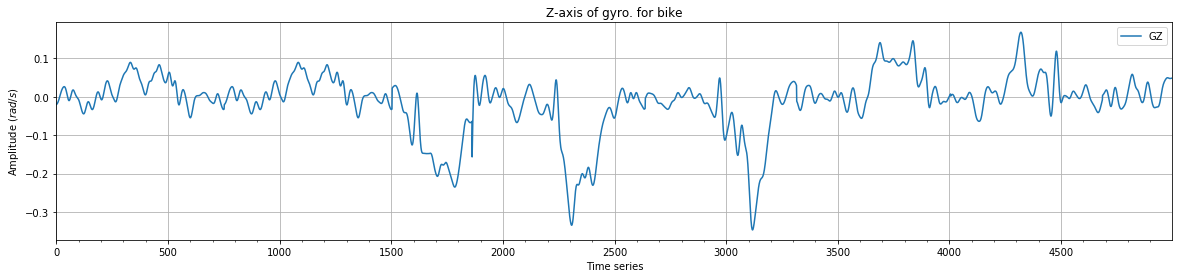

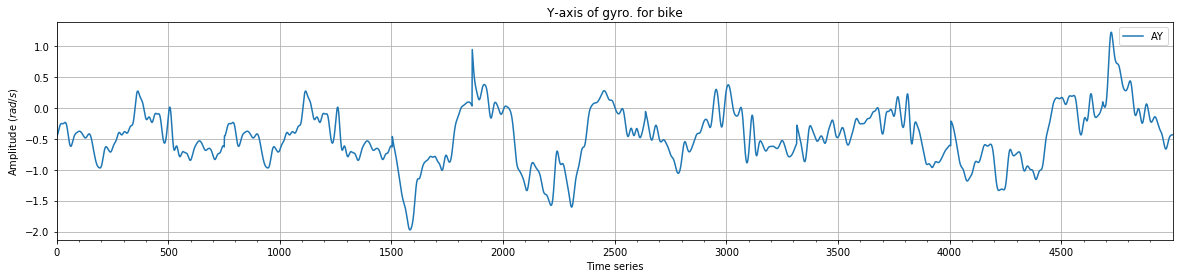

In [77]:
fig, ax = plt.subplots()
m=5000
df[['GZ']][0:m].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. for bike")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
n = len(df[0:m])
major_ticks = np.arange(0, n, 500)
minor_ticks = np.arange(0, n, 100)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
fig.savefig('abc.png') 

plt.grid(True)

fig, ax = plt.subplots()
df[['AY']][0:m].plot(figsize = (20,4),ax=ax, title = "Y-axis of gyro. for bike")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
n = len(df[0:m])
major_ticks = np.arange(0, n, 500)
minor_ticks = np.arange(0, n, 100)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
fig.savefig('abc.png') 

plt.grid(True)

In [75]:
car_segments, car_labels = segmentation(df, 500)
np.array(car_segments).shape



(681, 6, 500)

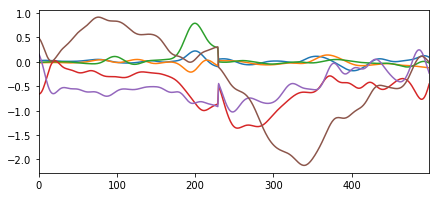

In [51]:
x = car_segments[109][0]
xx = pd.Series(x)
xx.plot(figsize = (7,3))
x = car_segments[109][1]
xx = pd.Series(x)
xx.plot(figsize = (7,3))
x = car_segments[109][2]
xx = pd.Series(x)
xx.plot(figsize = (7,3))
x = car_segments[109][3]
xx = pd.Series(x)
xx.plot(figsize = (7,3))
x = car_segments[109][4]
xx = pd.Series(x)
xx.plot(figsize = (7,3))
x = car_segments[109][5]
xx = pd.Series(x)
xx.plot(figsize = (7,3))




In [52]:
def DTWdistance(segments, ref_seg_no):
    y = segments
    DTW_list = []
    for i in range(len(segments[1])):
        x = segments[ref_seg_no][i]
        diff = loss_for_segments(y, x, i)
        DTW_list.append(diff)
    
    return DTW_list
        

In [53]:
ref_seq_no = 42
dtw_data = DTWdistance(car_segments, ref_seq_no)

0 => 4.82156444867
1 => 5.42748824536
2 => 6.07523903127
3 => 6.38279465202
4 => 5.33869250509
5 => 4.90561960305
6 => 4.67637120527
7 => 3.90611851499
8 => 3.73846325708
9 => 3.19331901261
10 => 2.96331241524
11 => 2.72984254196
12 => 2.70756496955
13 => 2.82538044073
14 => 4.05083581678
15 => 4.79083953685
16 => 5.40007386888
17 => 6.05217019619
18 => 6.42388992211
19 => 5.37187838588
20 => 4.91841597637
21 => 4.69224283047
22 => 4.04732640327
23 => 3.97153103229
24 => 3.72561121009
25 => 3.72400563829
26 => 3.10476712117
27 => 1.87881217347
28 => 1.27210281207
29 => 1.38984070728
30 => 2.03384438641
31 => 2.70884449296
32 => 3.86457019454
33 => 4.3547805656
34 => 3.80721915962
35 => 3.22403595343
36 => 2.66336688141
37 => 3.544325913
38 => 3.28258906274
39 => 3.03259744187
40 => 2.64731999033
41 => 0.550338966912
42 => 0.0
43 => 0.798306702518
44 => 2.60977740682
45 => 2.94050843597
46 => 3.5887864743
47 => 3.42994060565
48 => 2.90293974519
49 => 2.92362105199
50 => 2.64678245727
51

398 => 3.86535854662
399 => 3.68260096128
400 => 3.45316554198
401 => 3.68539900393
402 => 4.77378498368
403 => 5.60938821321
404 => 6.2646624626
405 => 6.77425991308
406 => 6.32290625596
407 => 5.03448572884
408 => 5.0847670441
409 => 5.11953725524
410 => 4.29855713237
411 => 4.12105179365
412 => 1.75202242831
413 => 1.46522199747
414 => 1.60135588118
415 => 2.0987300018
416 => 2.80164655323
417 => 3.45026124529
418 => 3.70540111782
419 => 3.57123557037
420 => 2.95488234376
421 => 1.94166858085
422 => 1.67907306798
423 => 2.11470140545
424 => 2.79569749875
425 => 3.22250893389
426 => 3.33470339049
427 => 3.18975036174
428 => 3.18887386764
429 => 3.68356950426
430 => 4.24663283968
431 => 4.88760152136
432 => 5.74179530821
433 => 5.05210257193
434 => 4.50510741548
435 => 4.25478787756
436 => 3.69879337582
437 => 3.32844862023
438 => 2.94137436331
439 => 2.85708045892
440 => 2.55951066659
441 => 2.50044571526
442 => 2.06508922238
443 => 2.2635625729
444 => 2.36922255001
445 => 2.74105844

115 => 1.20813518177
116 => 1.08793494305
117 => 1.63726254244
118 => 2.8235974437
119 => 2.93267165869
120 => 3.20396611024
121 => 2.99594487678
122 => 2.70449081887
123 => 2.59786883218
124 => 2.76594166293
125 => 3.73860190609
126 => 4.00383886345
127 => 4.08662493564
128 => 3.39417480218
129 => 3.36341610337
130 => 3.18407660867
131 => 2.99933783199
132 => 3.96666425104
133 => 4.31258246354
134 => 4.43494253298
135 => 4.88185424259
136 => 5.47032933033
137 => 6.47343855652
138 => 7.02403470583
139 => 6.32605475817
140 => 6.27058913661
141 => 5.92919046584
142 => 5.89070098828
143 => 5.99479735176
144 => 5.68998367275
145 => 5.34275681998
146 => 4.78223962949
147 => 3.77865792344
148 => 2.92056866947
149 => 2.76208935102
150 => 2.74610176181
151 => 2.51079484897
152 => 2.46806278024
153 => 2.55183800837
154 => 3.2928715262
155 => 4.09870494525
156 => 4.16889997579
157 => 4.91178246556
158 => 5.32656123304
159 => 6.21476881619
160 => 6.27828935334
161 => 5.47680072471
162 => 5.011052

507 => 2.73991911991
508 => 2.60289013593
509 => 1.58110402708
510 => 1.75652602744
511 => 1.74782022349
512 => 2.65107597844
513 => 3.3733054206
514 => 3.40399347776
515 => 3.08765703486
516 => 2.9234325913
517 => 2.74609098637
518 => 2.8826052287
519 => 3.1399391678
520 => 3.29380743455
521 => 3.09290871085
522 => 3.55249540209
523 => 3.36883632481
524 => 3.0164885252
525 => 1.79821861207
526 => 0.798146436834
527 => 1.2161911181
528 => 2.3106854774
529 => 2.29542560573
530 => 3.48691141741
531 => 2.82837383059
532 => 2.85273406815
533 => 2.4495548162
534 => 3.66128895197
535 => 3.31628782891
536 => 3.28841572067
537 => 3.63639772159
538 => 3.81080055005
539 => 4.52860925924
540 => 4.90909195419
541 => 4.50152371884
542 => 4.0271104966
543 => 3.53620392193
544 => 3.03406209161
545 => 2.31343841274
546 => 2.29496091433
547 => 2.23506928617
548 => 2.49237049008
549 => 2.64833701424
550 => 2.80817217598
551 => 2.4591291619
552 => 2.96289664476
553 => 3.39433683389
554 => 3.31084199683
5

224 => 4.42671313764
225 => 4.36719185264
226 => 3.94125062993
227 => 3.53266242267
228 => 3.15710893443
229 => 4.58159374108
230 => 4.72472165968
231 => 4.84780465119
232 => 5.31363943321
233 => 5.7244109329
234 => 6.02773060995
235 => 4.70884919232
236 => 4.03638210875
237 => 4.54781312157
238 => 5.01925906183
239 => 4.23027761214
240 => 3.6413989023
241 => 2.68556124655
242 => 1.20744735023
243 => 0.459191936333
244 => 0.687306515825
245 => 1.40655134233
246 => 3.20079830612
247 => 4.90738128752
248 => 5.12307291976
249 => 5.18311624741
250 => 4.96954866509
251 => 5.63334588855
252 => 4.9940217043
253 => 4.40051107815
254 => 4.43196262951
255 => 4.38945023955
256 => 3.90831054062
257 => 3.08368073087
258 => 3.56697677706
259 => 3.36412756677
260 => 3.15112857747
261 => 3.31263456732
262 => 3.03850838484
263 => 3.00730366299
264 => 2.90255589296
265 => 2.85455892396
266 => 2.96122614917
267 => 3.36121822994
268 => 3.43113373408
269 => 3.12200106288
270 => 3.32431141364
271 => 3.18224

616 => 0.885391884934
617 => 0.870028528012
618 => 1.69646928171
619 => 2.55628064739
620 => 3.22094689408
621 => 3.36186020716
622 => 2.8692620705
623 => 2.6955220626
624 => 2.61363063425
625 => 2.45910567991
626 => 2.32981548286
627 => 2.82977721629
628 => 3.27265421157
629 => 3.7319381232
630 => 4.17616881034
631 => 4.31538811931
632 => 4.11956591431
633 => 3.83288985511
634 => 3.62011604084
635 => 3.22617615953
636 => 2.84873198904
637 => 2.46242225978
638 => 2.47729325214
639 => 2.70914239872
640 => 2.86607494651
641 => 3.10885598112
642 => 3.35612371285
643 => 3.01943375137
644 => 2.43479809402
645 => 1.88234382581
646 => 1.11548316114
647 => 1.61269120906
648 => 2.2750944667
649 => 3.27634459372
650 => 3.69612170143
651 => 4.15414361877
652 => 3.90208589585
653 => 3.63262433415
654 => 3.40848397398
655 => 3.24770282308
656 => 3.05053622204
657 => 2.91889352935
658 => 2.98203831323
659 => 2.89431187428
660 => 2.90372584207
661 => 2.76818725048
662 => 2.61793312526
663 => 2.660632

333 => 14.6309425227
334 => 14.5642104142
335 => 12.7277977746
336 => 11.7099222018
337 => 8.94477287405
338 => 10.7983124197
339 => 14.4831314969
340 => 20.5338533897
341 => 24.5417426656
342 => 20.1801464316
343 => 12.7960938291
344 => 5.62780385281
345 => 1.55467368134
346 => 5.04509514402
347 => 11.8213334213
348 => 16.8827271641
349 => 20.7856784247
350 => 20.2122039124
351 => 17.3958142172
352 => 16.0640607721
353 => 16.8963684216
354 => 16.4950185818
355 => 15.4127243964
356 => 13.5671527707
357 => 12.2089916497
358 => 8.61116714126
359 => 6.29793307477
360 => 7.79726526492
361 => 10.3008717787
362 => 15.0446528577
363 => 18.1888398314
364 => 19.2091379752
365 => 19.3872948418
366 => 16.3494772764
367 => 12.8481655283
368 => 9.87378464407
369 => 9.54293432367
370 => 11.9318693758
371 => 14.2050229634
372 => 16.1860423344
373 => 18.2620014346
374 => 20.4088817061
375 => 17.4318003519
376 => 11.9824829774
377 => 8.98289518551
378 => 10.3414133651
379 => 13.3861859263
380 => 18.177

47 => 17.5811272768
48 => 19.0978317015
49 => 17.6352080797
50 => 13.856793624
51 => 10.9740712782
52 => 9.39390438819
53 => 8.34216142004
54 => 9.42407262576
55 => 12.9369209403
56 => 15.7388818645
57 => 16.6434164403
58 => 17.0019477297
59 => 15.4873571785
60 => 13.6747570848
61 => 11.3743098822
62 => 9.90687982465
63 => 9.30187961248
64 => 9.85883431154
65 => 9.71658234499
66 => 10.4560406062
67 => 11.0003670631
68 => 12.3585892168
69 => 14.0333419979
70 => 14.8188452781
71 => 17.5629923986
72 => 18.0762178527
73 => 16.4816884228
74 => 16.1146090901
75 => 16.9721154131
76 => 14.7403151483
77 => 13.9191552604
78 => 14.3883195827
79 => 13.1666309058
80 => 12.9741146943
81 => 9.92873569457
82 => 4.75220218505
83 => 4.65203225163
84 => 5.25649976991
85 => 10.8744802634
86 => 14.2739539811
87 => 14.0779710457
88 => 16.0425733032
89 => 18.6899313184
90 => 19.504201065
91 => 21.8060832231
92 => 22.7518149755
93 => 23.6598632004
94 => 22.4603355701
95 => 18.2049799999
96 => 15.3981569812
97

442 => 13.6826058597
443 => 12.1780497177
444 => 12.7431288688
445 => 11.6803731984
446 => 11.3990349407
447 => 10.9860881863
448 => 13.3342858752
449 => 14.5054175574
450 => 15.3035018774
451 => 16.5535326583
452 => 17.0755973024
453 => 15.780730889
454 => 13.8706781936
455 => 11.4985599137
456 => 10.7999963924
457 => 11.1288831092
458 => 12.0620623894
459 => 12.4888012526
460 => 13.8558085209
461 => 13.1672945766
462 => 12.3791292751
463 => 11.3662296149
464 => 10.5802697765
465 => 10.0529297045
466 => 8.95170562045
467 => 9.29148509115
468 => 10.3964725767
469 => 12.2681559566
470 => 14.4094483668
471 => 16.4209010971
472 => 18.6940791265
473 => 18.5189863115
474 => 16.3365287411
475 => 14.2853332138
476 => 12.058637622
477 => 12.0337727842
478 => 12.2529346819
479 => 13.6181859661
480 => 13.9447902096
481 => 14.8047924344
482 => 14.241276721
483 => 12.8032158538
484 => 12.0929440963
485 => 11.5893606618
486 => 12.3044523321
487 => 13.5607519967
488 => 14.326283131
489 => 15.1452381

160 => 19.5018030659
161 => 26.2244762032
162 => 32.8968265545
163 => 36.6987234984
164 => 33.3474945422
165 => 27.9645802388
166 => 23.5238968662
167 => 17.9761603171
168 => 10.3965325499
169 => 7.08409070649
170 => 11.151070759
171 => 13.4414210137
172 => 15.9605661203
173 => 20.8618872018
174 => 28.0706501455
175 => 33.5360592701
176 => 34.4287542919
177 => 27.488865038
178 => 21.6612724276
179 => 17.3858996322
180 => 16.5966334987
181 => 18.4505604809
182 => 21.6244138288
183 => 22.3346109016
184 => 18.7773994811
185 => 11.6053456977
186 => 7.58365326504
187 => 8.22458854641
188 => 9.86950636538
189 => 14.7398915761
190 => 18.6834554926
191 => 18.326092859
192 => 19.2041111632
193 => 17.665695438
194 => 16.2378202976
195 => 20.7919882593
196 => 26.9683188354
197 => 33.1275126661
198 => 35.179383153
199 => 31.7726745743
200 => 24.9417450062
201 => 19.1268052661
202 => 12.6963134779
203 => 8.40276101611
204 => 9.59190407799
205 => 12.9854092383
206 => 17.4260233613
207 => 19.61530938

553 => 15.1791676714
554 => 15.2000892507
555 => 17.045239169
556 => 20.7527050184
557 => 26.484425758
558 => 32.9529562346
559 => 36.4851901667
560 => 30.6999185427
561 => 25.5173064146
562 => 21.3024124804
563 => 14.4661578391
564 => 8.03848828101
565 => 8.17520401452
566 => 12.8552772326
567 => 15.0012556699
568 => 19.0045373649
569 => 25.2276397124
570 => 31.6072243989
571 => 35.5002090754
572 => 30.0454461448
573 => 21.5152245135
574 => 16.3869753732
575 => 12.768969796
576 => 10.4456984079
577 => 8.29824331056
578 => 12.5603816837
579 => 17.7446337341
580 => 18.6870385973
581 => 19.3029055413
582 => 17.8765654765
583 => 15.4579249052
584 => 13.4735608078
585 => 11.8890906997
586 => 11.5289804128
587 => 17.2609753357
588 => 24.1313913157
589 => 31.1623865838
590 => 34.1066594772
591 => 30.8119893424
592 => 25.6178795176
593 => 21.5153152178
594 => 15.0614259231
595 => 7.50938245976
596 => 6.24586164417
597 => 8.79021588261
598 => 11.0240192224
599 => 16.3637355021
600 => 21.513493

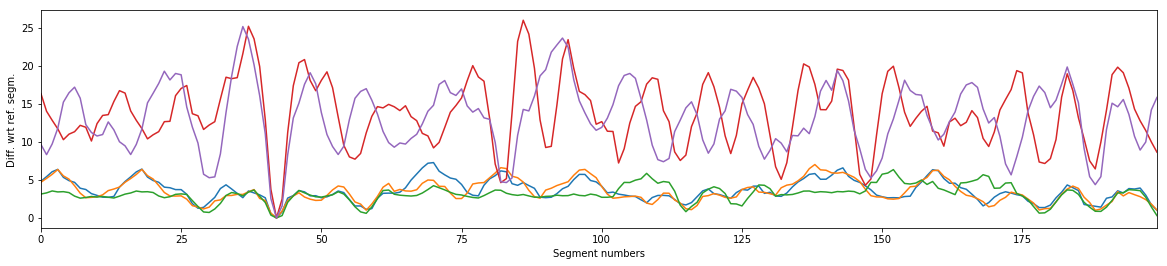

In [81]:

for i in range(5):
    loss_series_st = pd.Series(dtw_data[i])
    loss_series_st[0:200].plot(figsize =(20,4))
    plt.xlabel('Segment numbers')
    plt.ylabel('Diff. wrt ref. segm.')


In [55]:
path_acc = os.getcwd() + '/data/Car1109out/*/*AccelerometerLinear.csv'  
path_gyro= os.getcwd() + '/data/Car1109out/*/*Gyroscope.csv' 
acc_files = glob.glob(path_acc)
gyro_files= glob.glob(path_gyro)
df1= read_files(acc_files[0], gyro_files[0], 'car')
n = len(df1)
df1 = df1[350:n-500]
for acc_file, gyro_file in zip(acc_files, gyro_files) :
    print(acc_file)
    print(gyro_file)
    df_this = read_files(acc_file, gyro_file, 'car')
    n = len(df_this)
    print("len of this file ",df_this.shape)
    df_this = df_this[350 : n-500]
    print("len of this file ",df_this.shape)
#     print(df_this.columns)
    df1 = pd.concat([df1, df_this])
    print(df1.shape)
df1.reset_index(drop = True, inplace = True)
df1.head()

/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109out/2018-09-11_19-14-12/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109out/2018-09-11_19-14-12/Gyroscope.csv
len of this file  (3622, 15)
len of this file  (2772, 15)
(5544, 15)
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109out/2018-09-11_18-46-25/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109out/2018-09-11_18-46-25/Gyroscope.csv
len of this file  (6310, 15)
len of this file  (5460, 15)
(11004, 15)
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109out/2018-09-11_18-55-22/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109out/2018-09-11_18-55-22/Gyroscope.csv
len of this file  (2872, 15)
len of this file  (2022, 15)
(13026, 15)
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109out/2018-09-11_19-17-04/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109out/2018-09-11_19-17-04/Gyros

,AX,AY,AZ,GX,GY,GZ,activity,mAcc,mGyro,fAX,fAY,fAZ,fGX,fGY,fGZ
0,0.151147,-0.548212,0.384174,0.014104,0.032599,0.212953,car,-0.004297,0.086552,-0.469010,0.643091,1.045992,-0.469010,0.643091,1.045992
1,0.145558,-0.549001,0.315767,0.022043,0.024087,0.209872,car,-0.029225,0.085334,1.508135,0.300526,3.560223,1.508135,0.300526,3.560223
2,0.131640,-0.550599,0.237944,0.029397,0.016481,0.205640,car,-0.060338,0.083839,-0.479914,-0.919118,-0.239622,-0.479914,-0.919118,-0.239622
3,0.109519,-0.552682,0.153242,0.035762,0.010158,0.200435,car,-0.096640,0.082119,1.438879,0.072317,3.113115,1.438879,0.072317,3.113115
4,0.079650,-0.554942,0.064491,0.040765,0.005447,0.194477,car,-0.136934,0.080230,0.231024,-0.323009,0.435065,0.231024,-0.323009,0.435065


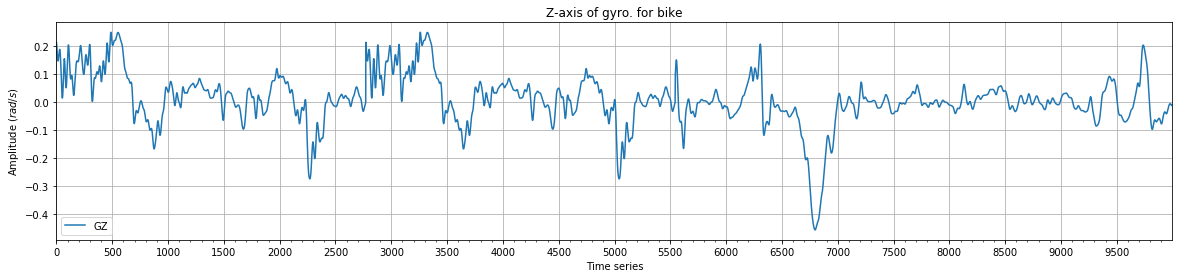

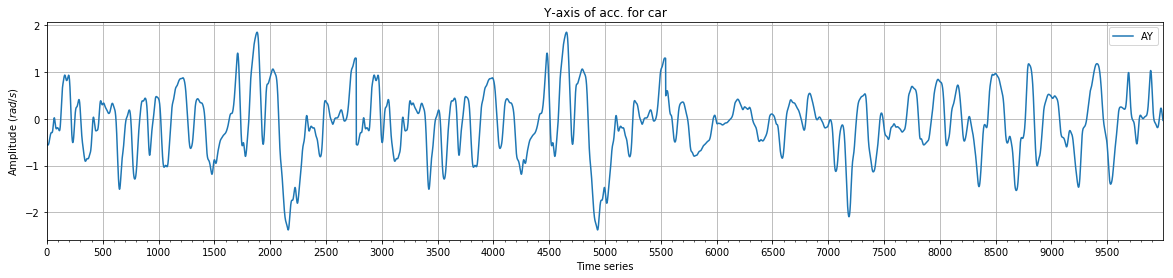

In [76]:
fig, ax = plt.subplots()
m=10000
df1[['GZ']][0:m].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. for bike")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
n = len(df1[0:m])
major_ticks = np.arange(0, n, 500)
minor_ticks = np.arange(0, n, 100)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
fig.savefig('abc.png') 

plt.grid(True)


plt.grid(True)
fig, ax = plt.subplots()
df1[['AY']][0:m].plot(figsize = (20,4),ax=ax, title = "Y-axis of acc. for car")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
n = len(df1[0:m])
major_ticks = np.arange(0, n, 500)
minor_ticks = np.arange(0, n, 100)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
fig.savefig('abc.png') 

plt.grid(True)

In [57]:
car_segments1, car_labels1 = segmentation(df1, 500)
np.array(car_segments1).shape
len(car_segments1)

1397

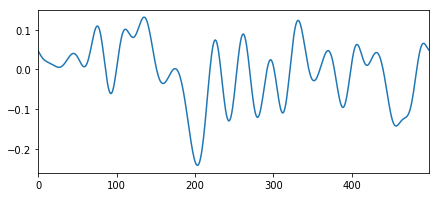

In [58]:
x = car_segments1[129][5]
xx = pd.Series(x)
xx.plot(figsize = (7,3))

In [59]:
ref_seq_no = 129
dtw_data_for_car = DTWdistance(car_segments1, ref_seq_no)

0 => 0.734393474917
1 => 0.611256369504
2 => 0.600041324907
3 => 0.626267442322
4 => 0.356104785288
5 => 0.411970903969
6 => 0.202618612806
7 => 0.227466343764
8 => 0.267724617565
9 => 0.354766748802
10 => 0.296397706359
11 => 0.346020325637
12 => 0.259194369018
13 => 0.391436272507
14 => 0.389351980737
15 => 0.419092557816
16 => 0.43065993035
17 => 0.395153188918
18 => 0.448733931516
19 => 0.377567028559
20 => 0.689635520979
21 => 0.751246461653
22 => 0.759535122141
23 => 0.680022560506
24 => 0.771263141176
25 => 0.782635895666
26 => 0.844955488333
27 => 0.833941598086
28 => 0.80447497824
29 => 0.861646669849
30 => 0.715952157575
31 => 0.496381669995
32 => 0.411328823767
33 => 0.490005069743
34 => 0.566835926519
35 => 0.542190583987
36 => 0.371006230223
37 => 0.492359868387
38 => 0.380995831952
39 => 0.416706924278
40 => 0.314110358283
41 => 0.370128551123
42 => 0.322281102102
43 => 0.313725464884
44 => 0.28264170692
45 => 0.316406049285
46 => 0.487998572103
47 => 0.457359995051
48 =>

380 => 0.290697248218
381 => 0.236677331553
382 => 0.264124474219
383 => 0.825612005209
384 => 0.832363325098
385 => 0.857454869792
386 => 0.809562233196
387 => 0.745240310134
388 => 0.745469533389
389 => 0.725157546679
390 => 0.749366215073
391 => 0.885661763504
392 => 1.18896175333
393 => 1.07421233836
394 => 1.17739314718
395 => 1.23520585021
396 => 1.23430177762
397 => 1.18872448429
398 => 1.13181698236
399 => 1.18349683125
400 => 1.17448782997
401 => 1.14704471036
402 => 0.904506953172
403 => 0.719724052575
404 => 0.384275704063
405 => 0.351719675765
406 => 0.280918907845
407 => 0.858755142499
408 => 0.872474657112
409 => 0.870953173331
410 => 0.81943115133
411 => 0.763362065672
412 => 0.819246147051
413 => 0.782442555634
414 => 0.750336854226
415 => 0.751043739979
416 => 0.955532644486
417 => 0.527494054763
418 => 0.243081539065
419 => 0.247779737959
420 => 0.285360053431
421 => 0.292051302488
422 => 0.293633026323
423 => 0.324150349917
424 => 0.279108191471
425 => 0.323242620418

759 => 0.725257940081
760 => 0.651708068244
761 => 0.726084744665
762 => 0.737843851623
763 => 0.626226664551
764 => 0.545694285581
765 => 0.508204486646
766 => 0.609102224746
767 => 0.553070097559
768 => 0.595699878278
769 => 0.445904203599
770 => 0.502596876633
771 => 0.492011194256
772 => 0.660514511149
773 => 0.636493074979
774 => 0.551004276906
775 => 0.908495612632
776 => 1.17233738103
777 => 1.13527011761
778 => 1.14985480897
779 => 1.02667141461
780 => 1.04742473032
781 => 1.04781350913
782 => 0.94096379278
783 => 0.900572736112
784 => 1.03151132488
785 => 0.803119824951
786 => 0.341356212713
787 => 0.315868559848
788 => 0.371875049907
789 => 0.320242156817
790 => 0.37940178959
791 => 0.345022361415
792 => 0.306158666293
793 => 0.405739431679
794 => 0.500993315057
795 => 0.513917537688
796 => 0.537610302407
797 => 0.560230438519
798 => 0.488638300657
799 => 0.422808883779
800 => 0.346639772387
801 => 0.404443457093
802 => 0.495155585779
803 => 0.557444720337
804 => 0.5629937266

1130 => 0.338356877386
1131 => 0.315751543895
1132 => 0.370104901655
1133 => 0.348927051828
1134 => 0.269597133519
1135 => 0.290891062877
1136 => 0.395911399453
1137 => 0.364125174217
1138 => 0.256307933374
1139 => 0.250223273003
1140 => 0.279855722172
1141 => 0.32062057985
1142 => 0.246212133313
1143 => 0.356926897146
1144 => 0.215595320503
1145 => 0.254779791181
1146 => 0.323238448318
1147 => 0.189168573345
1148 => 0.272275831013
1149 => 0.842570361166
1150 => 0.917551403416
1151 => 0.918816979772
1152 => 0.943141724461
1153 => 0.841746154864
1154 => 0.835268812373
1155 => 0.856187468254
1156 => 0.842964213525
1157 => 0.857541513903
1158 => 0.926732005183
1159 => 0.52256553833
1160 => 0.528348759941
1161 => 0.555313839038
1162 => 0.277358989886
1163 => 0.211101378128
1164 => 0.457875804002
1165 => 0.451081330356
1166 => 0.422605309922
1167 => 0.448664044606
1168 => 0.441103333541
1169 => 0.408638601317
1170 => 0.438200330007
1171 => 0.372661433017
1172 => 0.421117827622
1173 => 0.468

102 => 0.847923056176
103 => 0.984170933912
104 => 1.12969664177
105 => 1.13361183454
106 => 1.07654027251
107 => 0.985495950961
108 => 0.952884075938
109 => 0.922223734674
110 => 0.881410664124
111 => 0.86406813858
112 => 0.974082907967
113 => 0.976701580649
114 => 1.05162421422
115 => 0.869450634835
116 => 0.737209370759
117 => 0.995723606083
118 => 1.0429958257
119 => 1.15962979756
120 => 1.02679780865
121 => 1.05212561083
122 => 1.07136730868
123 => 1.18781099921
124 => 0.884603044774
125 => 0.660552281849
126 => 0.669299023887
127 => 0.509340244326
128 => 0.183773835114
129 => 0.0
130 => 0.303680944547
131 => 0.6335215707
132 => 0.641901346586
133 => 0.786131640086
134 => 0.968184814084
135 => 1.04909465317
136 => 1.10038445102
137 => 1.01196659771
138 => 1.04770245806
139 => 0.861044925279
140 => 0.823578785108
141 => 0.797929599783
142 => 0.762420763593
143 => 0.782013718552
144 => 0.913147887557
145 => 0.836033809454
146 => 0.81229041745
147 => 0.81180064323
148 => 0.6614906417

480 => 0.867490080635
481 => 0.789397068385
482 => 0.853000478752
483 => 0.853898266044
484 => 0.920398587046
485 => 0.926746596178
486 => 0.867031082389
487 => 0.875084964752
488 => 0.930558056805
489 => 0.866721715547
490 => 0.871046701512
491 => 0.90430004938
492 => 0.92097721239
493 => 0.91952817477
494 => 0.890632669235
495 => 0.906739466311
496 => 0.857301572017
497 => 0.886789404411
498 => 0.863127640495
499 => 0.843873380551
500 => 0.871250076307
501 => 0.93459063263
502 => 0.884885710091
503 => 0.758593318575
504 => 0.702246341045
505 => 0.792346313545
506 => 0.854788295258
507 => 0.817759827191
508 => 0.728852617142
509 => 0.797260606637
510 => 0.823883825925
511 => 0.924070964215
512 => 0.844332255333
513 => 0.869447306145
514 => 0.729972940585
515 => 0.75929101514
516 => 0.799657802247
517 => 0.839686876894
518 => 0.854806947229
519 => 0.914379433934
520 => 1.15566423381
521 => 1.30665517444
522 => 1.28133241203
523 => 1.3580156721
524 => 1.36404022496
525 => 1.25374096773


859 => 0.728044470495
860 => 0.787957431425
861 => 0.777399599011
862 => 0.869519938155
863 => 0.941183982392
864 => 0.971333743043
865 => 1.0717013669
866 => 1.23076190883
867 => 1.22562607198
868 => 1.30326432501
869 => 1.38053587206
870 => 1.25696926736
871 => 1.02176485294
872 => 0.932537848435
873 => 0.701985037763
874 => 0.870855064116
875 => 0.985134532973
876 => 0.866765017077
877 => 0.888792353421
878 => 0.949480019913
879 => 0.836818452808
880 => 0.893129211953
881 => 0.819145721374
882 => 0.784783143765
883 => 0.734937177582
884 => 0.793335294653
885 => 0.631511761041
886 => 0.563516301546
887 => 0.344124914945
888 => 0.377973926124
889 => 0.44743027143
890 => 0.606037659486
891 => 0.470600570899
892 => 0.757181229347
893 => 0.930610260708
894 => 1.08116728809
895 => 1.18507358088
896 => 1.26913127866
897 => 1.26314888988
898 => 1.2929475996
899 => 1.02269409574
900 => 0.878065743194
901 => 0.789745024785
902 => 0.818714894619
903 => 0.835372623824
904 => 0.76743806317
905 =

1228 => 1.02616548065
1229 => 1.08686679794
1230 => 1.1241253572
1231 => 1.05841236166
1232 => 1.13906910303
1233 => 1.2686038187
1234 => 1.16574845165
1235 => 1.11670842142
1236 => 1.0110881723
1237 => 0.979880852088
1238 => 0.868062220002
1239 => 0.880246035287
1240 => 0.83670823536
1241 => 0.858440160825
1242 => 0.695723153119
1243 => 0.720434493402
1244 => 0.855620669983
1245 => 0.764647982933
1246 => 0.756784633238
1247 => 0.805522185069
1248 => 0.835036098075
1249 => 0.871735493257
1250 => 0.808110907424
1251 => 0.745262624992
1252 => 0.731616825779
1253 => 0.664925987704
1254 => 0.671130374276
1255 => 0.731586462194
1256 => 0.709259795735
1257 => 0.749795022543
1258 => 0.815600964958
1259 => 0.864212227517
1260 => 0.800349474408
1261 => 0.665390065546
1262 => 0.592415731815
1263 => 0.658488657449
1264 => 0.71154332089
1265 => 0.761541427328
1266 => 0.790910940712
1267 => 0.802981139906
1268 => 0.868788315368
1269 => 0.982393375253
1270 => 0.983791865877
1271 => 1.01205330901
127

214 => 6.48778844025
215 => 5.9936163034
216 => 5.62801320045
217 => 5.34651767146
218 => 5.18541003968
219 => 5.07593434118
220 => 4.52219722312
221 => 4.38354684164
222 => 4.36192222505
223 => 4.48183336743
224 => 4.2402995663
225 => 4.57432566448
226 => 4.88899303426
227 => 4.9865619493
228 => 4.86801446332
229 => 4.90378014615
230 => 4.97999388248
231 => 4.8793164782
232 => 4.8787310462
233 => 4.94746116262
234 => 4.9852539616
235 => 4.88028322583
236 => 4.72179336174
237 => 4.53111849822
238 => 4.05503148372
239 => 4.09275807381
240 => 4.2731365371
241 => 4.5685754885
242 => 4.77834176536
243 => 4.66707766185
244 => 4.69823623455
245 => 4.84203305441
246 => 5.07542201963
247 => 5.02066223001
248 => 4.91400510795
249 => 4.8034119782
250 => 4.85761685859
251 => 4.94325887135
252 => 4.91517072344
253 => 4.95703531111
254 => 5.03255839355
255 => 5.15266385677
256 => 5.12465847877
257 => 4.99261337609
258 => 4.86021850895
259 => 4.78560379804
260 => 4.70795678988
261 => 4.64076308251
2

607 => 7.38556170852
608 => 6.40819634204
609 => 5.49566647547
610 => 4.77840952451
611 => 4.56085296723
612 => 4.99955018457
613 => 5.46415156413
614 => 4.76647254911
615 => 4.71345773412
616 => 5.2501765767
617 => 5.15073200132
618 => 5.56180936264
619 => 5.51066359784
620 => 5.70710498625
621 => 5.87937980654
622 => 5.00076549421
623 => 3.84167318503
624 => 2.85975537954
625 => 3.14225346393
626 => 4.30162039354
627 => 5.26383977504
628 => 5.49571201789
629 => 5.5092308146
630 => 5.75523980126
631 => 5.82344832234
632 => 5.68059884995
633 => 5.92355792305
634 => 5.68106320044
635 => 5.20775393055
636 => 5.15606046806
637 => 5.25219852719
638 => 5.12583559982
639 => 4.91207183717
640 => 4.88311047266
641 => 4.92030066322
642 => 4.5264061643
643 => 3.92382911701
644 => 4.01576504503
645 => 4.55027786051
646 => 5.06105993394
647 => 5.00833935746
648 => 4.84742241864
649 => 4.71880081063
650 => 4.69375475432
651 => 4.70995695152
652 => 4.84298686523
653 => 4.89074174717
654 => 4.8807128

999 => 4.69362696223
1000 => 4.62384358452
1001 => 4.60809509125
1002 => 4.69619852964
1003 => 4.80435771307
1004 => 4.93955137313
1005 => 4.91701400488
1006 => 4.61873377435
1007 => 4.38093174378
1008 => 4.21865788167
1009 => 4.23967535416
1010 => 4.40523922111
1011 => 4.58171098065
1012 => 4.77522701586
1013 => 4.80457579478
1014 => 4.73498344231
1015 => 4.75554437749
1016 => 4.68227607171
1017 => 4.70318565341
1018 => 4.79224192762
1019 => 4.80795924872
1020 => 4.81041379425
1021 => 4.83893654372
1022 => 4.8647794583
1023 => 4.84293780904
1024 => 4.8112699332
1025 => 4.81908969848
1026 => 4.87626794455
1027 => 4.93546620198
1028 => 4.91713690892
1029 => 4.84965728096
1030 => 4.78044974504
1031 => 4.79721644268
1032 => 4.87253615751
1033 => 4.88299924543
1034 => 4.76454479697
1035 => 4.60089710683
1036 => 4.54439891716
1037 => 4.61918509238
1038 => 4.36804483107
1039 => 4.18508226226
1040 => 4.36779574757
1041 => 4.67064195519
1042 => 4.74195520463
1043 => 4.48745892839
1044 => 4.369

1375 => 4.77396169938
1376 => 4.67522360652
1377 => 4.66932538059
1378 => 4.77676681279
1379 => 4.84894683547
1380 => 4.68150739735
1381 => 4.57323969786
1382 => 4.60018357034
1383 => 4.6149731093
1384 => 4.5179322085
1385 => 4.45477211321
1386 => 4.64142629426
1387 => 4.75224141431
1388 => 4.62207104217
1389 => 4.26121505978
1390 => 3.78570640717
1391 => 3.58416989864
1392 => 3.55573997075
1393 => 3.89051100905
1394 => 3.95323475288
1395 => 4.12890226785
1396 => 4.51071879761
0 => 9.21056163411
1 => 11.5880550292
2 => 11.5551929138
3 => 13.2355367179
4 => 14.6284830213
5 => 12.36333572
6 => 9.1250305321
7 => 6.23308940083
8 => 7.28213894492
9 => 8.05667126902
10 => 8.46210706763
11 => 7.00417885144
12 => 9.21766059307
13 => 13.8509279838
14 => 15.7919915106
15 => 14.6592821883
16 => 14.2400030588
17 => 14.755859292
18 => 15.3008269187
19 => 14.5913105524
20 => 12.1308060822
21 => 10.5769621907
22 => 10.99948189
23 => 13.0606214561
24 => 11.5700432159
25 => 8.88879403743
26 => 5.172149

376 => 9.83317080172
377 => 9.47024143608
378 => 10.8555690751
379 => 10.8633806476
380 => 10.3354685114
381 => 10.63411427
382 => 10.6301301634
383 => 11.0940641492
384 => 11.4736343522
385 => 10.06890252
386 => 8.71433332748
387 => 9.49798451123
388 => 10.1095825886
389 => 10.6994363743
390 => 10.2523201109
391 => 9.52153583525
392 => 9.51404054943
393 => 8.8827548228
394 => 7.94387888034
395 => 9.41299855308
396 => 9.60465497307
397 => 7.05271909063
398 => 7.43052000904
399 => 9.65746471534
400 => 11.2519375364
401 => 17.7711148851
402 => 22.9682410177
403 => 22.9225510242
404 => 21.1574972371
405 => 20.4614542231
406 => 18.1239024569
407 => 17.3446674033
408 => 17.462474856
409 => 15.899590043
410 => 13.573473625
411 => 12.8127331098
412 => 12.012189839
413 => 10.7465512428
414 => 10.977035648
415 => 12.0234684761
416 => 10.6141127331
417 => 10.6467656203
418 => 10.7055793949
419 => 10.0005442549
420 => 10.2012267724
421 => 11.1574833614
422 => 11.3229770038
423 => 10.1488082155
42

768 => 10.9058921706
769 => 11.0434900751
770 => 7.93093867913
771 => 11.1082550097
772 => 16.8540981184
773 => 20.6781217847
774 => 23.3887557332
775 => 25.8190588503
776 => 22.9412317239
777 => 18.985558135
778 => 17.4399221614
779 => 16.8015544417
780 => 18.0806630653
781 => 17.3833103491
782 => 13.1009323175
783 => 11.3405736774
784 => 10.8382362009
785 => 9.9446620635
786 => 11.3146967208
787 => 10.0883262546
788 => 10.0753556744
789 => 11.9517368527
790 => 9.21930991361
791 => 6.95970517956
792 => 7.32897844034
793 => 7.36853337775
794 => 9.76239259438
795 => 11.2642300987
796 => 8.34794550839
797 => 8.46825730654
798 => 11.6942425008
799 => 10.6648842187
800 => 10.0832144293
801 => 4.74465834194
802 => 7.68501446976
803 => 7.82923046439
804 => 11.6043830667
805 => 17.0674540729
806 => 20.7596761599
807 => 21.8426991619
808 => 20.6959306398
809 => 18.9141789874
810 => 17.6265286779
811 => 17.4820121349
812 => 17.3506129098
813 => 15.4720186884
814 => 13.9994670803
815 => 13.13810

1153 => 8.50566674272
1154 => 8.26256284707
1155 => 10.295688489
1156 => 12.2130754232
1157 => 11.6279960241
1158 => 12.3031071765
1159 => 12.5091278716
1160 => 11.1880644319
1161 => 10.0769041768
1162 => 9.8143377921
1163 => 9.95620082421
1164 => 11.0881727707
1165 => 11.4485373685
1166 => 11.9334311683
1167 => 12.1540923514
1168 => 12.5745860431
1169 => 13.3353719537
1170 => 12.1161192361
1171 => 10.9636237845
1172 => 10.9976185191
1173 => 11.0970328672
1174 => 11.0415960256
1175 => 11.6702222331
1176 => 11.456543436
1177 => 10.6623998345
1178 => 10.0313746795
1179 => 9.81142453331
1180 => 9.98811274647
1181 => 10.5752422931
1182 => 11.2260158927
1183 => 11.1874706137
1184 => 11.6421712703
1185 => 12.2255901462
1186 => 12.8661647176
1187 => 12.0432921502
1188 => 11.1217081424
1189 => 10.6024794276
1190 => 10.8428624686
1191 => 11.1083944519
1192 => 10.709897323
1193 => 10.460265579
1194 => 10.3554563879
1195 => 9.88164391148
1196 => 9.99014812548
1197 => 10.4501204544
1198 => 10.5447

142 => 10.8771596191
143 => 16.3622371089
144 => 10.3330560195
145 => 7.50076566277
146 => 7.42950846815
147 => 8.46798391688
148 => 8.04260071472
149 => 7.69004962318
150 => 8.10340390404
151 => 5.57412075168
152 => 8.22282835281
153 => 9.58480786594
154 => 6.89692388612
155 => 6.47168258857
156 => 6.04159609963
157 => 12.9130628165
158 => 11.9753082429
159 => 13.2807689335
160 => 13.2447354269
161 => 11.979681375
162 => 12.3309304402
163 => 10.1169409853
164 => 12.2722616316
165 => 13.6717102942
166 => 16.0192955853
167 => 15.4291893464
168 => 16.7084710217
169 => 16.9649410906
170 => 12.7792209208
171 => 9.25220208763
172 => 9.46022291387
173 => 14.0362074308
174 => 10.2492139351
175 => 12.6643048122
176 => 13.4702606858
177 => 13.920537756
178 => 14.1704451067
179 => 13.7115875789
180 => 13.1027538359
181 => 11.7524127173
182 => 13.21914764
183 => 12.7416021694
184 => 13.8897246433
185 => 14.3693420109
186 => 15.4850150493
187 => 11.1428851249
188 => 10.4464326226
189 => 5.73750628

535 => 14.4657012535
536 => 12.545559139
537 => 9.63930521765
538 => 6.35542903212
539 => 6.48649345619
540 => 11.0194858561
541 => 12.3707819982
542 => 13.0692140911
543 => 12.1711870125
544 => 12.3732904186
545 => 13.8062723574
546 => 8.62149531553
547 => 8.92589269485
548 => 8.24464246792
549 => 11.2782409422
550 => 11.9839101183
551 => 9.17554449872
552 => 10.098687872
553 => 8.93122706828
554 => 9.54557193884
555 => 9.73292738188
556 => 10.8018812582
557 => 11.4037610919
558 => 9.51893834359
559 => 5.56489255145
560 => 6.30648486866
561 => 9.85299910028
562 => 7.66143469513
563 => 3.16655555152
564 => 4.99516731052
565 => 10.3442398803
566 => 7.43429021907
567 => 5.12461380697
568 => 7.76769782179
569 => 7.51091070186
570 => 6.37038347499
571 => 7.32783510633
572 => 11.8006517506
573 => 12.1639093096
574 => 12.3248239123
575 => 9.20256129075
576 => 11.6188110475
577 => 14.4374272041
578 => 17.1303873036
579 => 16.1421341215
580 => 14.6842895237
581 => 17.6002357337
582 => 15.83507

927 => 13.1093879922
928 => 9.14504004396
929 => 8.77417069157
930 => 9.98908993716
931 => 8.66092109226
932 => 11.76038554
933 => 13.523726894
934 => 13.8657203071
935 => 12.5932644555
936 => 13.5050966394
937 => 9.68674332614
938 => 8.13802437082
939 => 10.0693304794
940 => 8.03010230871
941 => 7.1110522533
942 => 6.62690741893
943 => 5.27911793094
944 => 5.13187456184
945 => 6.96605615801
946 => 5.55127097441
947 => 4.47228302276
948 => 7.62262907062
949 => 10.3991097232
950 => 9.93101337814
951 => 9.09586686767
952 => 9.13844919125
953 => 11.2592083057
954 => 7.05572472374
955 => 8.4885888393
956 => 6.47195811469
957 => 11.9612840377
958 => 12.1265755737
959 => 11.5405958868
960 => 8.85059457778
961 => 8.21171240631
962 => 8.54663164756
963 => 8.48115225334
964 => 9.39570804428
965 => 12.6695506769
966 => 14.1342596558
967 => 13.3507980133
968 => 10.0693631009
969 => 13.6874832952
970 => 15.1123855227
971 => 11.9135121258
972 => 8.74719756696
973 => 11.6810044489
974 => 15.35285007

1305 => 5.30111364862
1306 => 8.68423262021
1307 => 12.5706218924
1308 => 10.9335231794
1309 => 9.01062068781
1310 => 8.94339336123
1311 => 12.2331143316
1312 => 9.11992090115
1313 => 8.20622170165
1314 => 9.29417936464
1315 => 7.74871742724
1316 => 7.16796183734
1317 => 6.47415359537
1318 => 7.91374300605
1319 => 9.83530460046
1320 => 12.9332225137
1321 => 10.8099160737
1322 => 9.89200558736
1323 => 8.66926711971
1324 => 8.64728539634
1325 => 6.14203060084
1326 => 7.76317129984
1327 => 11.8108870075
1328 => 11.5828822193
1329 => 11.5030675169
1330 => 12.2239109279
1331 => 15.1116671183
1332 => 13.1534763541
1333 => 14.6885128217
1334 => 14.2785874406
1335 => 14.3822134767
1336 => 10.4147674659
1337 => 10.7777434783
1338 => 14.0628710305
1339 => 12.4605057927
1340 => 9.84121329077
1341 => 9.97479874559
1342 => 15.1890862311
1343 => 11.7417250959
1344 => 9.50526612951
1345 => 10.8974810218
1346 => 8.69094951709
1347 => 10.55397011
1348 => 12.7739081575
1349 => 13.5940827406
1350 => 9.92

302 => 1.32608844669
303 => 1.07841804736
304 => 0.927310397007
305 => 1.06737035462
306 => 1.1030319764
307 => 1.08233349565
308 => 1.34737543545
309 => 1.16723945539
310 => 1.35040610534
311 => 1.22734917918
312 => 1.27474577171
313 => 1.35686307904
314 => 1.40656546272
315 => 1.88011635766
316 => 2.43317895178
317 => 2.25972770633
318 => 2.01910883317
319 => 2.60611421281
320 => 2.20115637146
321 => 2.41183743386
322 => 2.37009688507
323 => 2.46683119469
324 => 3.03204466446
325 => 3.30001522663
326 => 3.4644801944
327 => 3.60700048909
328 => 3.79275761639
329 => 2.89611442473
330 => 3.03983895215
331 => 3.86623648256
332 => 4.14349893116
333 => 4.65462579042
334 => 3.78751584369
335 => 3.67557728879
336 => 2.37641779381
337 => 2.27426754883
338 => 2.88702118736
339 => 3.04677334373
340 => 3.23187647532
341 => 2.1075969378
342 => 1.98219609317
343 => 2.05690268187
344 => 1.61548934079
345 => 1.56689300895
346 => 1.42226729744
347 => 1.70805574627
348 => 1.62586637739
349 => 2.273069

695 => 1.37978544996
696 => 1.29654474649
697 => 1.47788215237
698 => 0.979535764765
699 => 1.09802299453
700 => 1.20217330062
701 => 0.966028869065
702 => 1.25362450238
703 => 1.43770448417
704 => 1.55873930576
705 => 1.27390376584
706 => 1.34074069348
707 => 1.19447284477
708 => 1.64581702286
709 => 1.34400631973
710 => 1.5216017134
711 => 1.20576748118
712 => 1.40741709839
713 => 1.40964207075
714 => 1.52765184759
715 => 1.42441805743
716 => 1.45411824264
717 => 1.27234363502
718 => 1.64808884609
719 => 1.79009856252
720 => 2.09173630475
721 => 1.76647548963
722 => 1.93704227197
723 => 2.11784373541
724 => 2.12922235765
725 => 1.85655440993
726 => 1.87486640448
727 => 2.57569237586
728 => 2.77121043274
729 => 2.90643364088
730 => 2.25271337669
731 => 2.31356355831
732 => 2.72000436982
733 => 3.25776804649
734 => 3.66054533907
735 => 3.67139357149
736 => 3.91192547878
737 => 3.72117230451
738 => 3.86354813985
739 => 3.69405918431
740 => 4.75293121365
741 => 4.11743498118
742 => 4.317

1083 => 1.46417016975
1084 => 1.44912094336
1085 => 1.41428801045
1086 => 1.7606837026
1087 => 1.53946963503
1088 => 1.7329318074
1089 => 1.76141766526
1090 => 1.87154478131
1091 => 1.38317352288
1092 => 1.3385282477
1093 => 1.53002282886
1094 => 2.33475198196
1095 => 2.39293250911
1096 => 2.43931339271
1097 => 1.8549311947
1098 => 1.7760765874
1099 => 1.87634978648
1100 => 1.84864472865
1101 => 1.42810393599
1102 => 1.24368881755
1103 => 1.1260478152
1104 => 1.82016651529
1105 => 2.31555168999
1106 => 2.38490958303
1107 => 2.51909242933
1108 => 2.1978509948
1109 => 2.32097140711
1110 => 2.12731304662
1111 => 2.25014477206
1112 => 2.2016527666
1113 => 2.5384527443
1114 => 2.64592246298
1115 => 2.25219159912
1116 => 1.66846969307
1117 => 1.46646161844
1118 => 1.36441739481
1119 => 1.55305720495
1120 => 1.25954722573
1121 => 1.34395922727
1122 => 1.33241689792
1123 => 1.40779504384
1124 => 1.34601788194
1125 => 1.22630376725
1126 => 1.06372101859
1127 => 1.1255959949
1128 => 1.2061050029

In [60]:
print(np.array(dtw_data).shape)
print(np.array(dtw_data_for_car).shape)


(6, 681)
(6, 1397)


In [61]:

train1 = dtw_data
label1 = [1]*len(train1[0])
train2 = dtw_data_for_car
label2 = [0]*len(train2[0])
train = [x+y for x,y in zip(train1, train2)]
# train = train1 + train2
label = label1 + label2
train = [*zip(*train)]



In [62]:
RANDOM_SEED = 42
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2, random_state=RANDOM_SEED)

In [63]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))


1662
1662
416
416


In [64]:

# train a random forest
clf = RandomForestClassifier(n_estimators=200)

In [65]:
# get the 5-fold cross-validation score
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores, scores.mean(), scores.std())

[ 1.          0.99399399  0.996997    1.          0.99697885] 0.997593968591 0.00224822307303


In [66]:

# apply model to test set
clf.fit(X_train, y_train)
predict_y = clf.predict(X_test)
print(predict_y)

[1 0 0 0 0 1 0 1 0 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 1 0 0
 0 0 1 0 0 0 0 1 0 1 0 0 1 1 1 0 1 1 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0
 0 0 0 0 1 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 1 0 0 0 1
 1 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0 1
 0 0 0 1 0 1 1 1 1 0 0 0 0 0 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 1 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0
 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1
 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 1 1 0 0 1 1 1 0 1 0 1 0 0 0 1 1 1 0 0 1 0 1
 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 1 0 1 1 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1
 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 1 0 0 0 0 0 1
 0 0 0 0 1 0 0 1 1]


In [67]:

# obtain accuracy score
testscore = accuracy_score(y_test, predict_y)
print("Accuracy score on test set: %6.3f" % testscore)

Accuracy score on test set:  0.998


In [68]:
from sklearn import svm
svm_clf = svm.SVC(kernel='linear', C=1)

In [69]:
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=5)
print(svm_scores, svm_scores.mean(), svm_scores.std())

[ 0.996997    1.          0.996997    0.99698795  0.99697885] 0.997592159553 0.00120393901452


In [70]:
# apply model to test set
svm_clf.fit(X_train, y_train)
predict_y = svm_clf.predict(X_test)
print(predict_y)

[1 0 0 0 0 1 0 1 0 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 1 0 0
 0 0 1 0 0 0 0 1 0 1 0 0 1 1 1 0 1 1 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0
 0 0 0 0 1 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 1 0 0 0 1
 1 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0 1
 0 0 0 1 0 1 1 1 1 0 0 0 0 0 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 1 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0
 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1
 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 1 1 0 1 0 1 0 0 0 1 1 1 0 0 1 0 1
 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 1 0 1 1 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1
 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 0 0 0 0 0 1
 0 0 0 0 1 0 0 1 1]


In [71]:
# obtain accuracy score
testscore = accuracy_score(y_test, predict_y)
print("Accuracy score on test set: %6.3f" % testscore)

Accuracy score on test set:  0.998


In [72]:
for i in range(len(predict_y)):
    print(y_test[i], " ", predict_y[i])
    print("-----")

1   1
-----
0   0
-----
0   0
-----
0   0
-----
0   0
-----
1   1
-----
0   0
-----
1   1
-----
0   0
-----
0   0
-----
1   1
-----
1   1
-----
0   0
-----
1   1
-----
1   1
-----
1   1
-----
1   1
-----
0   0
-----
0   0
-----
0   0
-----
0   0
-----
0   0
-----
0   0
-----
0   0
-----
0   0
-----
1   1
-----
0   0
-----
1   1
-----
0   0
-----
1   1
-----
0   0
-----
1   1
-----
0   0
-----
1   1
-----
1   1
-----
0   0
-----
0   0
-----
0   0
-----
0   0
-----
1   1
-----
0   0
-----
0   0
-----
0   0
-----
0   0
-----
1   1
-----
0   0
-----
1   1
-----
0   0
-----
0   0
-----
1   1
-----
1   1
-----
1   1
-----
0   0
-----
1   1
-----
1   1
-----
1   1
-----
0   0
-----
0   0
-----
0   0
-----
1   1
-----
0   0
-----
0   0
-----
1   1
-----
0   0
-----
0   0
-----
0   0
-----
0   0
-----
1   1
-----
0   0
-----
0   0
-----
0   0
-----
1   1
-----
1   1
-----
0   0
-----
0   0
-----
0   0
-----
0   0
-----
0   0
-----
1   1
-----
0   0
-----
1   1
-----
1   1
-----
0   0
-----
0   

In [ ]:

# Inspect feature importances
for i, ifeature in enumerate(features):
    print(ifeature + ': %6.4f' % clf.feature_importances_[i])

681
681


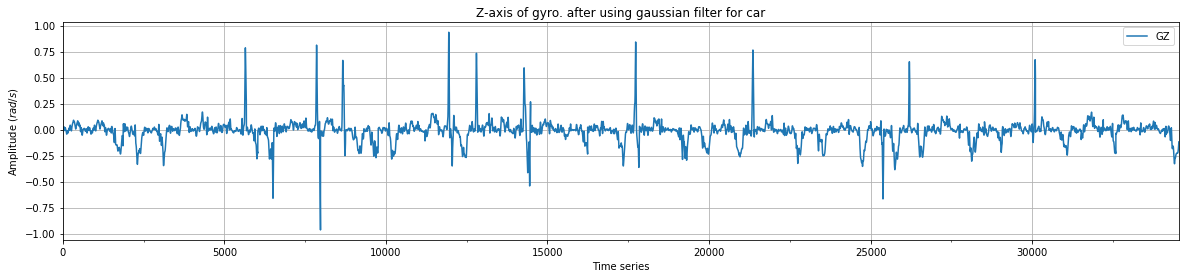

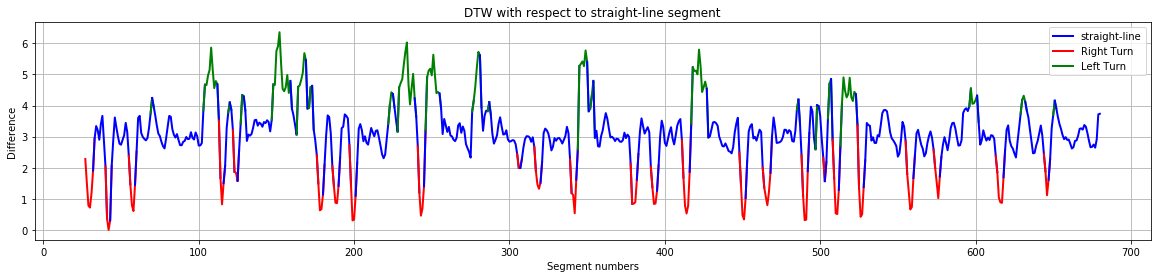

In [129]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig, ax = plt.subplots()
df[['GZ']].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. after using gaussian filter for car")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
n = len(df)
major_ticks = np.arange(0, n, 5000)
minor_ticks = np.arange(0, n, 2500)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

plt.grid(True)

legend_elements = [Line2D([0], [0], color='b', lw=2, label='straight-line'),
                   Line2D([0], [0], color='r', lw=2, label='Right Turn'),
                   Line2D([0], [0], color='g', lw=2, label='Left Turn')]

y = loss_series

x = np.arange(len(y))
print(len(y))
print(len(x))

car_colors = color_mapping(car_labelsy = car_segments[42][0])
car_colors
plot_multicolored_lines(x,y,car_colors)
plt.xlabel('Segment numbers')
plt.ylabel('Difference')
plt.title("DTW with respect to straight-line segment")
plt.legend(handles=legend_elements, loc='upper right')

plt.grid(True)
plt.show()

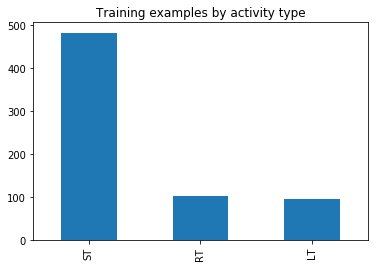

In [130]:
car_lables1= pd.Series(car_labels
                     )
car_lables1.value_counts().plot(kind='bar', title='Training examples by activity type');

In [131]:
x = car_segments
dist_fun = manhattan_distances
y = car_segments[11][0]
# dist, cost, acc, path = dtw(x, y, dist=lambda x, y: norm(x - y, ord=1))
diff_wrt_ST, car_labels1 = loss_for_segments(x, y ,dist_fun)
loss_series_st = pd.Series(diff_wrt_ST)
loss_series.to_csv('diff_wrt_ST_car')

0 => 0.818154175488
1 => 0.675586177917
2 => 0.812375363549
3 => 0.914436393927
4 => 0.808648762704
5 => 0.788313386796
6 => 0.845812670905
7 => 0.708417186624
8 => 0.6805169259
9 => 0.563645380371
10 => 0.30781014592
11 => 0.0
12 => 0.25821895558
13 => 0.425878394308
14 => 0.4683264722
15 => 0.822410635338
16 => 0.668889715747
17 => 0.795108841832
18 => 0.910706842279
19 => 0.81035034836
20 => 0.779774824208
21 => 0.869056576723
22 => 0.990364529333
23 => 1.1733711502
24 => 1.5054445976
25 => 1.97199891289
26 => 2.48402608637
27 => 2.33046943819
28 => 2.18276553119
29 => 2.28805455566
30 => 2.36055227842
31 => 2.31403124676
32 => 2.31411940374
33 => 2.24869634625
34 => 1.90699180899
35 => 1.60668664265
36 => 1.75487222592
37 => 2.40671021615
38 => 2.86891887835
39 => 2.81930299381
40 => 2.60309825019
41 => 2.69096384817
42 => 2.81787563316
43 => 2.74981842728
44 => 2.81602218325
45 => 2.650416194
46 => 2.43082780564
47 => 1.63759286816
48 => 1.07791486231
49 => 0.478830953722
50 => 0.

392 => 2.37028163806
393 => 2.41508965703
394 => 2.56419396149
395 => 2.46456539196
396 => 2.4777242864
397 => 2.29071339862
398 => 1.962822716
399 => 1.58517360273
400 => 0.855817555684
401 => 0.517263072937
402 => 0.697580003873
403 => 0.498698866138
404 => 0.485124528742
405 => 0.583423873129
406 => 0.774533614191
407 => 0.922574549611
408 => 1.63596691887
409 => 2.23566213571
410 => 2.79449951631
411 => 2.88950587813
412 => 2.61575560086
413 => 2.62521867015
414 => 2.78406995699
415 => 2.74994438917
416 => 2.77745640634
417 => 3.12212652744
418 => 4.36082006934
419 => 4.15037740577
420 => 4.08547413989
421 => 3.89658940611
422 => 3.82584028312
423 => 3.8271756296
424 => 3.96053788823
425 => 3.92381749091
426 => 3.90545198177
427 => 3.55582292272
428 => 0.46833663002
429 => 0.736076386052
430 => 0.7577308514
431 => 0.796384222946
432 => 0.875296751237
433 => 0.833023726291
434 => 0.856636750573
435 => 0.869090140117
436 => 0.811832406211
437 => 0.744492092932
438 => 0.726352051356
4

681
681


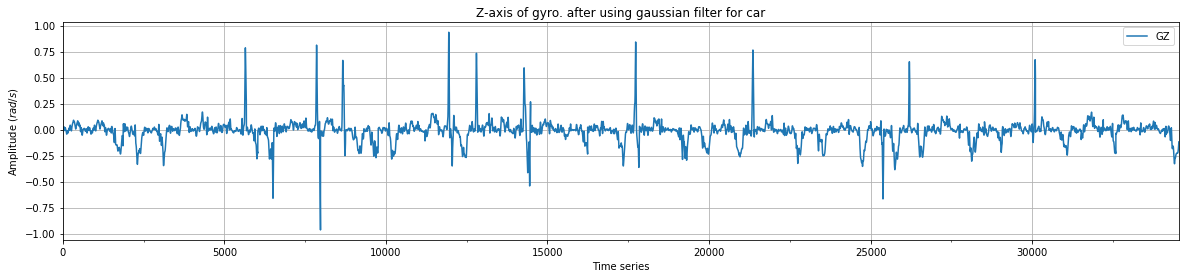

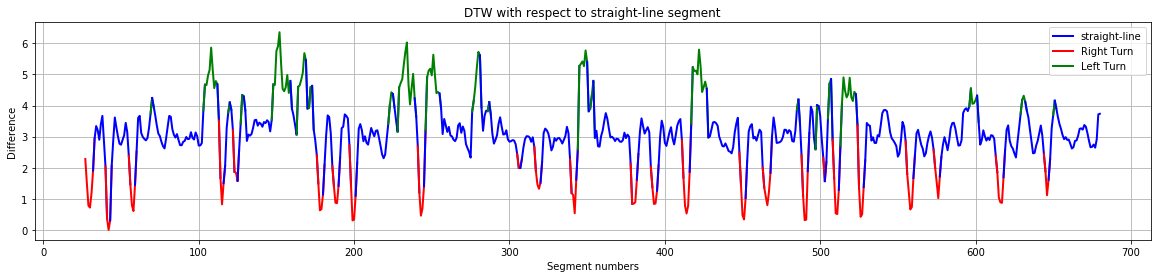

In [132]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig, ax = plt.subplots()
df[['GZ']].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. after using gaussian filter for car")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
n = len(df)
major_ticks = np.arange(0, n, 5000)
minor_ticks = np.arange(0, n, 2500)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

plt.grid(True)

legend_elements = [Line2D([0], [0], color='b', lw=2, label='straight-line'),
                   Line2D([0], [0], color='r', lw=2, label='Right Turn'),
                   Line2D([0], [0], color='g', lw=2, label='Left Turn')]

y = loss_series

x = np.arange(len(y))
print(len(y))
print(len(x))

car_colors = color_mapping(car_labels)
car_colors
plot_multicolored_lines(x,y,car_colors)
plt.xlabel('Segment numbers')
plt.ylabel('Difference')
plt.title("DTW with respect to straight-line segment")
plt.legend(handles=legend_elements, loc='upper right')

plt.grid(True)
plt.show()

In [143]:
x = car_segments
dist_fun = manhattan_distances
y = car_segments[109][0]
# dist, cost, acc, path = dtw(x, y, dist=lambda x, y: norm(x - y, ord=1))
diff_wrt_RT, car_labels1 = loss_for_segments(x, y ,dist_fun)
loss_series_rt = pd.Series(diff_wrt_RT)
loss_series.to_csv('diff_wrt_rT_car')

0 => 3.79218868926
1 => 3.66091895822
2 => 3.37958490204
3 => 3.41426367942
4 => 3.51334123298
5 => 3.39940383026
6 => 3.50096173126
7 => 3.61375849219
8 => 3.83654604513
9 => 3.90461534735
10 => 3.90652828971
11 => 3.79470578811
12 => 3.82278021414
13 => 3.89456499009
14 => 3.92591769938
15 => 3.78850769809
16 => 3.68473433168
17 => 3.3797178038
18 => 3.4107350994
19 => 3.52207831216
20 => 3.39932241365
21 => 3.49062578462
22 => 3.60453089762
23 => 3.8606952818
24 => 3.99976053327
25 => 4.04245520687
26 => 4.17065534879
27 => 4.28696970705
28 => 4.46572735401
29 => 4.47757967936
30 => 5.35506924885
31 => 5.5771500828
32 => 4.89708135744
33 => 4.25658984089
34 => 4.07159682003
35 => 3.89619035717
36 => 4.03104002319
37 => 4.18471359274
38 => 4.24855483233
39 => 4.52076078229
40 => 4.53556670586
41 => 4.44692969051
42 => 5.18406736168
43 => 5.86610731162
44 => 5.13855633132
45 => 4.97860215953
46 => 4.5511755217
47 => 4.1831339982
48 => 4.0329035268
49 => 3.88188303487
50 => 3.903939815

399 => 3.97991944452
400 => 3.81916533934
401 => 3.88220095557
402 => 3.9569316859
403 => 3.74980046277
404 => 3.45197427094
405 => 3.35482689479
406 => 3.4211711262
407 => 3.61030246646
408 => 3.42881853896
409 => 3.61978058825
410 => 4.18659224773
411 => 4.45488662468
412 => 4.65801916602
413 => 4.90341406131
414 => 5.48466565898
415 => 5.88778824945
416 => 5.25781340375
417 => 5.08105295907
418 => 6.00743853345
419 => 5.51181983512
420 => 5.1568623555
421 => 5.23892181509
422 => 1.59649885247
423 => 0.559192809783
424 => 0.777707025636
425 => 5.03643867809
426 => 5.05069204469
427 => 5.28668462161
428 => 3.86869390815
429 => 3.95547561974
430 => 3.72791129407
431 => 3.37377118205
432 => 3.37403839602
433 => 3.5515392159
434 => 3.39238495531
435 => 3.16614362659
436 => 3.21186899194
437 => 3.92125574374
438 => 3.95920021297
439 => 3.98221900133
440 => 3.95938425025
441 => 3.959316061
442 => 3.55623752717
443 => 3.57841143996
444 => 3.84598695638
445 => 3.90833896574
446 => 4.04091978

681
681


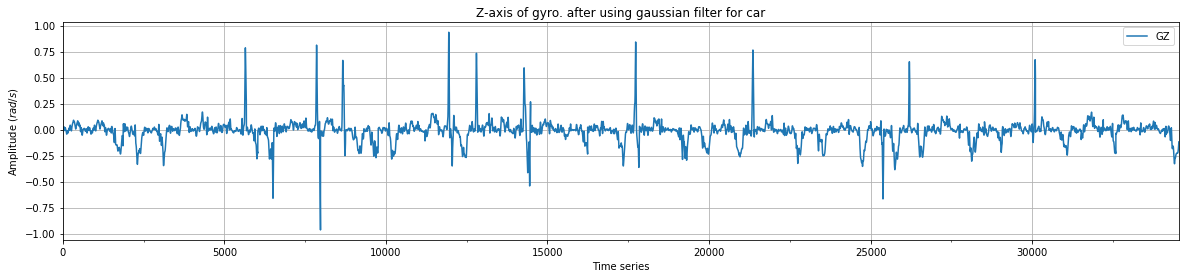

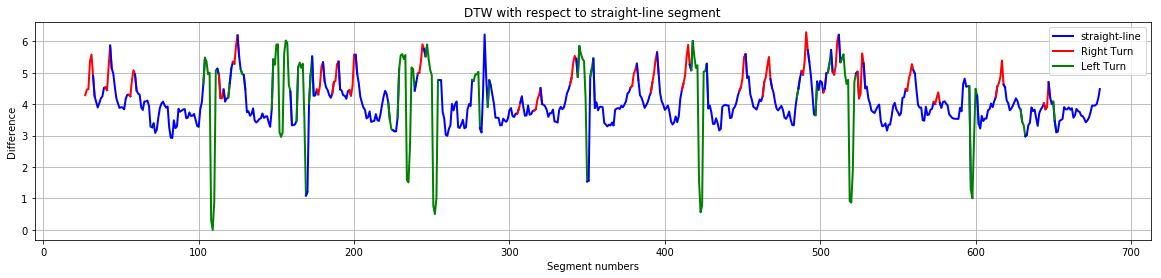

In [145]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig, ax = plt.subplots()
df[['GZ']].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. after using gaussian filter for car")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
n = len(df)
major_ticks = np.arange(0, n, 5000)
minor_ticks = np.arange(0, n, 2500)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

plt.grid(True)

legend_elements = [Line2D([0], [0], color='b', lw=2, label='straight-line'),
                   Line2D([0], [0], color='r', lw=2, label='Right Turn'),
                   Line2D([0], [0], color='g', lw=2, label='Left Turn')]

y = loss_series_rt

x = np.arange(len(y))
print(len(y))
print(len(x))

car_colors = color_mapping(car_labels)
car_colors
plot_multicolored_lines(x,y,car_colors)
plt.xlabel('Segment numbers')
plt.ylabel('Difference')
plt.title("DTW with respect to straight-line segment")
plt.legend(handles=legend_elements, loc='upper right')

plt.grid(True)
plt.show()

In [164]:
  
path_acc = os.getcwd() + '/data/Car1109in/*/*AccelerometerLinear.csv'  
path_gyro= os.getcwd() + '/data/Car1109in/*/*Gyroscope.csv' 

print(path_acc)

acc_files = glob.glob(path_acc)
gyro_files= glob.glob(path_gyro)
df1= read_files(acc_files[0], gyro_files[0], 'car')
n = len(df1)
df1 = df1[500:n-600]
for acc_file, gyro_file in zip(acc_files, gyro_files) :
    print(acc_file)
    print(gyro_file)
    df_this = read_files(acc_file, gyro_file, 'car')
    n = len(df_this)
    df_this = df_this[500 : n-600]
    print("len of this file ",df_this.shape)
    df1 = pd.concat([df1, df_this])
    print(df1.shape)
df1.reset_index(drop = True, inplace = True)
df1.head()


/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109in/*/*AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109in/2018-09-11_16-49-13/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109in/2018-09-11_16-49-13/Gyroscope.csv
len of this file  (700, 15)
(1400, 15)
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109in/2018-09-11_17-22-09/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109in/2018-09-11_17-22-09/Gyroscope.csv
len of this file  (83, 15)
(1483, 15)
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109in/2018-09-11_16-47-56/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109in/2018-09-11_16-47-56/Gyroscope.csv
len of this file  (959, 15)
(2442, 15)
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109in/2018-09-11_17-13-25/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109in/2018-09-11_17-13-25/Gyroscope.csv
len o

(26009, 15)
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109in/2018-09-11_16-57-20/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109in/2018-09-11_16-57-20/Gyroscope.csv
len of this file  (1016, 15)
(27025, 15)
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109in/2018-09-11_16-43-51/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109in/2018-09-11_16-43-51/Gyroscope.csv
len of this file  (1033, 15)
(28058, 15)
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109in/2018-09-11_16-38-52/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109in/2018-09-11_16-38-52/Gyroscope.csv
len of this file  (1049, 15)
(29107, 15)
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109in/2018-09-11_17-14-28/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109in/2018-09-11_17-14-28/Gyroscope.csv
len of this file  (311, 15)
(29418, 15)
/home/vicky/Desktop/Dhananjay/hum

,AX,AY,AZ,GX,GY,GZ,activity,mAcc,mGyro,fAX,fAY,fAZ,fGX,fGY,fGZ
0,-0.078869,-0.188007,0.070541,0.012077,0.007819,0.027154,car,-0.065445,0.015683,-0.825888,0.922741,-0.022174,-0.825888,0.922741,-0.022174
1,-0.076141,-0.195744,0.069358,0.012012,0.007699,0.026396,car,-0.067509,0.015369,0.384957,-0.430676,0.010557,0.384957,-0.430676,0.010557
2,-0.073515,-0.202591,0.067808,0.011851,0.007478,0.025336,car,-0.069433,0.014888,-0.822077,0.918355,-0.022309,-0.822077,0.918355,-0.022309
3,-0.071023,-0.208544,0.065932,0.011603,0.007182,0.024010,car,-0.071212,0.014265,0.384284,-0.430754,0.010639,0.384284,-0.430754,0.010639
4,-0.068689,-0.213629,0.063755,0.011284,0.006829,0.022459,car,-0.072855,0.013524,-0.818287,0.914052,-0.022004,-0.818287,0.914052,-0.022004


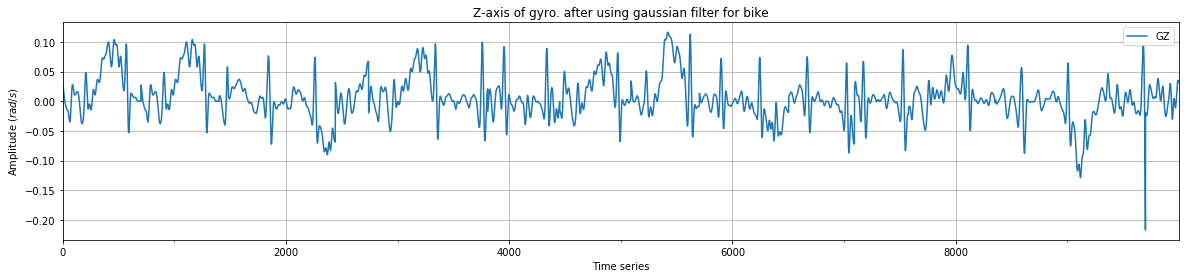

In [166]:
fig, ax = plt.subplots()
df1[['GZ']][0:10000].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. after using gaussian filter for bike")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
n = len(df1[0:10000])
major_ticks = np.arange(0, n, 2000)
minor_ticks = np.arange(0, n, 1000)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
fig.savefig('abc.png') 

plt.grid(True)

In [54]:
car_segments, car_labels = segmentation(df, 500)
np.array(car_segments).shape
print(len(car_segments))

681
